<a href="https://colab.research.google.com/github/XuCoder99/PASCO_Gyroscope_with_PINN/blob/main/Gyroscope_Classification_%26_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Project was designed for the gyroscope experiment originally from PASCO.

#Physics Section

From the manual, we can see that the motion of equation is derived with the assumption that the only component that is affected by external force (gravity for this case.) is the rotating disk. Yet, we can see that this isn't true.

Refer to the figure on the below, it introduces the process of obtaining the equation of motion of the gyroscope. In detail, it is the trajectory of the center of the rotating disk of the  

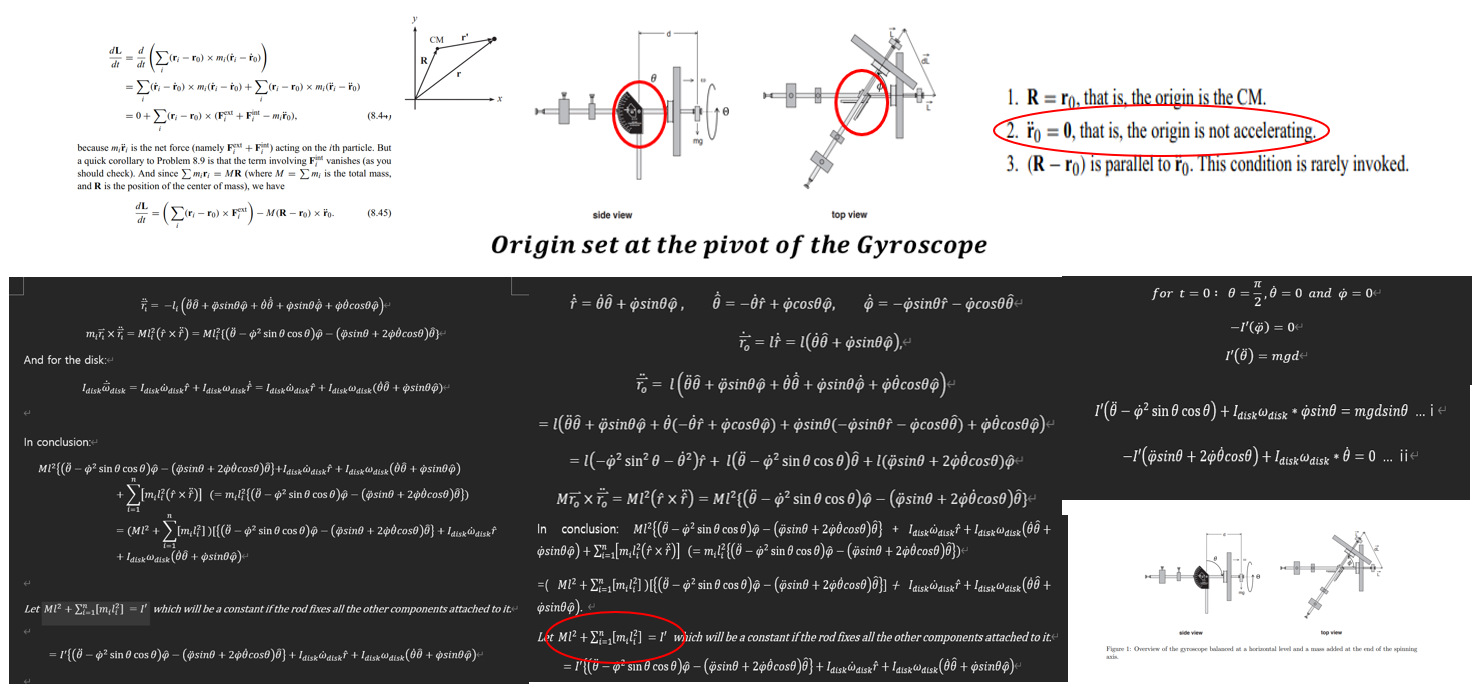

(Yes the process for obtaining the motion of equation of the gyroscope is indeed complex and exhausting.)

The image above depicts the equations of motion for the gyroscope, one for the azimuthal angle and the other for the polar angle of the gyroscope's disc with respect to its support. The main point is that from the organized equations, we can see that we need addtional information of the gyroscope's moment of inertia.

The following are for data implementation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
#import random

filename_100 = '/content/drive/MyDrive/Colab Notebooks/AI Physics textbook projects/23-2 project folder/Gyroscope Classification, PINN/EXP_DATA/100 g precession.xlsx'
filename_ren = '/content/drive/MyDrive/Colab Notebooks/AI Physics textbook projects/23-2 project folder/Gyroscope Classification, PINN/EXP_DATA/AIP data all in one.xlsx'
filename_50  = '/content/drive/MyDrive/Colab Notebooks/AI Physics textbook projects/23-2 project folder/Gyroscope Classification, PINN/EXP_DATA/50 g precession.xlsx'
#make sure to modify the path for the given experimental data so that the code and the machine learning part operates without error.

data_100 = pd.read_excel(filename_100)  # 20 Hz  0.05 s 단위시간
data_ren = pd.read_excel(filename_ren)  # 100 Hz 0.01 s 단위시간
data_50 = pd.read_excel(filename_50) # 20 Hz  0.05 s 단위시간

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ex_time=np.arange(0,10,0.01)  # Real time
I = 0.0105 # the moment of inertia of the disc attached to the gyroscope
m = 0.1 # the mass of the disc
g = 9.80665  # Gravitatoinal constant
d = 0.21 # the distance between the center of the disc and the pivot of the gyroscope

In [ ]:
# Bringing the raw data renewal.ver in the flesh.
time_pR1=[]; time_pR2=[];
time_pR3=[]; time_pR4=[];

AzimAng_pR1=[]; AzimAng_pR2=[];
AzimAng_pR3=[]; AzimAng_pR4=[];

for idx in range(0,1000): #1703
  time_pR1.append(data_ren['time1'][idx+135]-data_ren['time1'][135])
  AzimAng_pR1.append(data_ren['CCW run1'][idx+135]-data_ren['CCW run1'][135])

for idx2 in range(0,1000): #1423
  time_pR2.append(data_ren['time2'][idx2+100]-data_ren['time2'][100])
  AzimAng_pR2.append(data_ren['CCW run2'][idx2+100]-data_ren['CCW run2'][100])

for idx3 in range(0,500): #1525  ? 이건 200 Hz였나 왜 이렇게 해놨지.
  time_pR3.append(data_ren['time3'][idx3]-data_ren['time3'][0])
  AzimAng_pR3.append(data_ren['CW run1'][idx3]-data_ren['CW run1'][0])

for idx4 in range(0,1000): #1525
  time_pR4.append(data_ren['time4'][idx4]-data_ren['time4'][0])
  AzimAng_pR4.append(data_ren['CW run2'][idx4]-data_ren['CW run2'][0])


# Considering the decay of angular speed of the rotating disk
due to various reasons, the angular speed of the disk attached to the gyroscope will decrease (such as friction of the bearings or air resistance during precession(nutation).)


Since the experiment doesn't consider such decay(it assumes the angular speed as constant during the while precession(nutation) process) The following are various models that consider the decaying angular speed. The initial and final angular speed are collected by bare eyes of the conductor of the experiment.

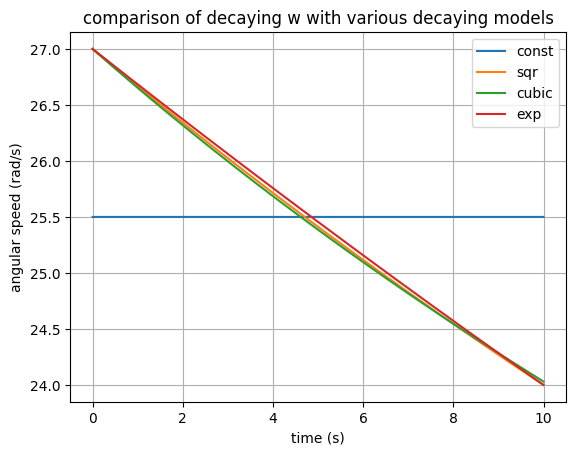

<Figure size 1920x1440 with 0 Axes>

In [ ]:
# Creating Datasets

w_const= []; w_sqre=[];
w_cube=[]; w_expo=[];

for j in range(0,10000):
  w_sqr = 1/((1/2160)*(0.001*j)+(1/27))
  w_cub = 1/np.sqrt(0.000036*0.001*j+(1/27)**2)
  w_exp = 27*np.exp(0.1*np.log(24/27)*0.001*j)

  w_sqre.append(w_sqr)
  w_cube.append(w_cub)
  w_const.append(25.5)
  w_expo.append(w_exp)

w_const=np.asarray(w_const)
w_sqre = np.asarray(w_sqre)
w_cube = np.asarray(w_cube)
w_expo = np.asarray(w_expo)

plt.title('comparison of decaying w with various decaying models')
plt.plot(np.arange(0,10,0.001),w_const, label='const')
plt.plot(np.arange(0,10,0.001),w_sqre, label='sqr')
plt.plot(np.arange(0,10,0.001),w_cube, label='cubic')
plt.plot(np.arange(0,10,0.001),w_expo, label='exp')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('angular speed (rad/s)')
plt.legend()
plt.figure(dpi=300)
plt.show()


Now we will generate a function that returns the azimuthal angle of the gyroscope's disc with respect to time. The input for the function would be the value of the moment of inertia of the gyroscope with respect to its pivot.

In [ ]:
def gen_phi(I_p, theta_val=0, w=w_sqre):

  t = np.pi/2   # initial polar angle
  t_d, p, p_d = 0, 0.0, 0  # initial azimuthal angle and the derivatives of polar,azimuthal angle with respect to time.

  time=10
  unit_t=0.001
  time_range=np.arange(0, time, unit_t)  # 10 k data points (time/unit_t) will be evaluated.
  P=[]
  Thet=[]

  for i in range(0, len(time_range)):
    t_dd = (m*g*d*np.sin(t)-I*w[i]*p_d*np.sin(t))/I_p + (p_d**2)*np.sin(t)*np.cos(t)
    p_dd = ( (I*w[i]*t_d)/I_p - 2*p_d*t_d*np.cos(t) ) / np.sin(t)  # the data points for the angular speed sample contains only 1k points. Don't just shove it in

    t_d = t_d + t_dd * unit_t
    p_d = p_d + p_dd * unit_t

    t = t + t_d * unit_t
    p = p + p_d * unit_t

   #extracting only 1k points among 100k

    if i%(10) ==0:   # 1000 data points out of 100 k -> divide it by 100(100000/ex_num)
      P.append(p)
      Thet.append(t)

  if(theta_val==1):
    return np.asarray(P), np.asarray(Thet)
  else:
    return  np.asarray(P) #, np.asarray(W)

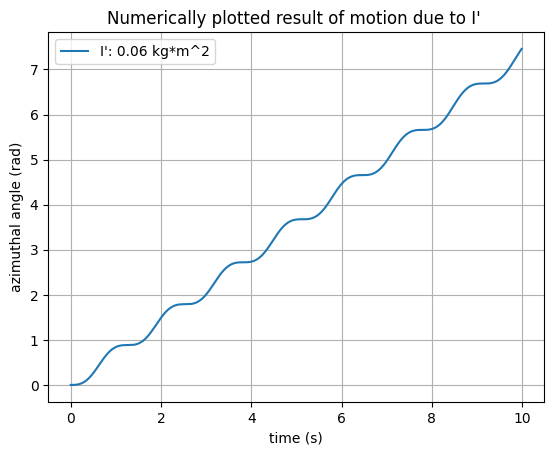

In [ ]:
#Testing the function
plt.title('Numerically plotted result of motion due to I\' ')
plt.plot(ex_time, gen_phi(0.06), label='I\': 0.06 kg*m^2')
plt.xlabel('time (s)')
plt.ylabel('azimuthal angle (rad)')
plt.legend()
plt.grid()
plt.show()

Actual experiment results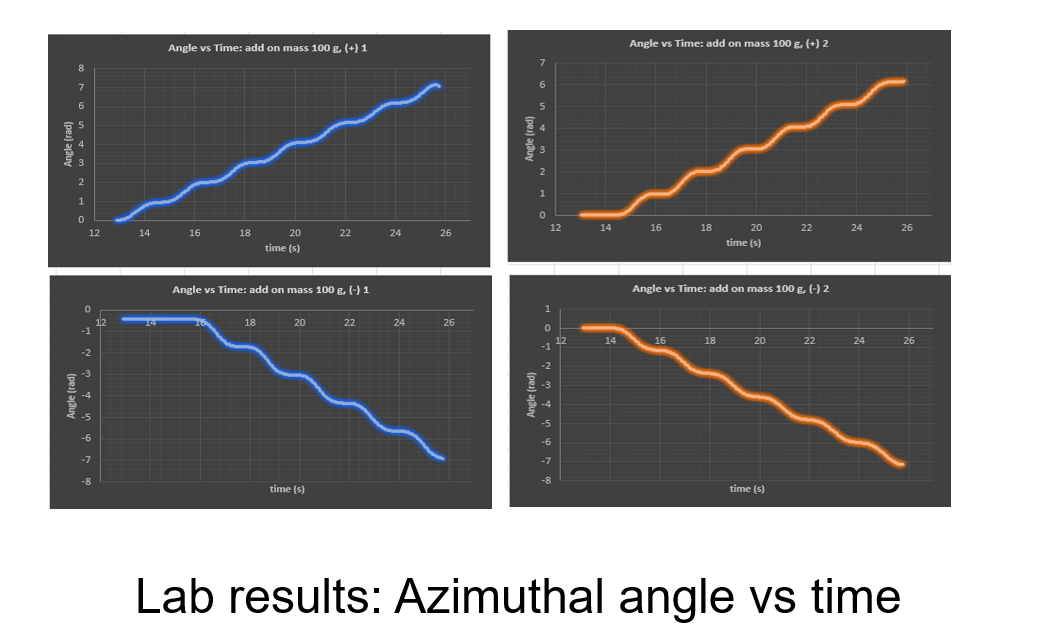

#Machine Learning section

the following code will find the the moment of inertia of the gyroscope with respect to its pivot. And after that, we will predict the movement of the gyroscope by applying Pinn.

# 1. Classification

The following code returns the average value of the azimuthal angle slope

In [ ]:
def slope_avg(Pangle, choose=2, ex_time=ex_time ):
  sum = 0

  for index2 in range(500,1000):  # (0,1000)
    if ex_time[index2]==0:
      sum+=0
    else:
      sum += Pangle[index2]/ex_time[index2]
  sum=sum/500   # 1000

  #line = np.arange(0,10*sum, (10*sum)/1000)
  line=[]
  for Notagain in range(0,1000):
    line.append(sum*0.01*Notagain)
  line=np.asarray(line)
  RtN = Pangle - line

  # or

  endd = Pangle[999]/10
  #line2 = np.arange(0, 10*endd, 10*endd/1000)
  line2=[]
  for Notagain2 in range(0,1000):
    line2.append(sum*0.01*Notagain2)
  line2=np.asarray(line2)
  RtN2 = Pangle - line2

  line_average = (np.max(RtN2) + np.min(RtN2))/2

  RtN2 = RtN2 - line_average
  #print(np.shape(RtN2))
  if choose ==1:
    return RtN

  elif choose ==0:
    return sum

  elif choose ==3:
    return line

  else:
    return RtN2

extracting the slope value from the rotation of the gyroscope

0.5822695745053149
0.6896601432766339




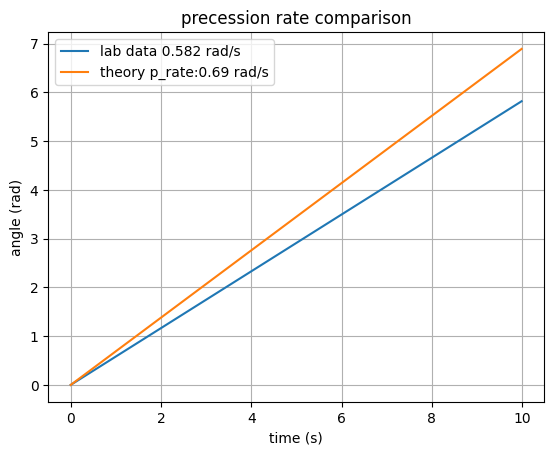

In [ ]:
def total_run(I_ppp, choose2=2):
  result = slope_avg(gen_phi(I_ppp), choose2)
  return result

# seeing an example as a result

print(slope_avg(AzimAng_pR1,0))
print(total_run(0.0982, 0))
print('\n')

plt.title('precession rate comparison')
plt.plot(ex_time, slope_avg(AzimAng_pR1,3), label='lab data {} rad/s'.format(round(slope_avg(AzimAng_pR1,0),3)))
plt.plot(ex_time, total_run(0.0982,3), label='theory p_rate:{} rad/s'.format(round(total_run(0.0982, 0), 3)))
plt.xlabel('time (s)')
plt.ylabel('angle (rad)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
I_p_list=[]
I_num = 200  #100
iteration = 10  # The total number of data points can be denoted as I_num * iteration

for i in range(0,I_num): # (Consider about modifying the range of I_num)
  I_p_list.append(round(0.085+0.0003*i, 5))
#I_p_list=random.shuffle(I_p_list)

class_I = []
for jebal_gm in range(0,I_num):
  class_I.append(jebal_gm)  # 0~99 total 100 ->200 indices are involved.


new_list=[]
new_list=I_p_list*iteration  # I_p list will be trained with 10 iterations
yyy=new_list

#For the dataset
category_y = class_I*iteration

print(I_p_list)

import random

category_y=random.sample(category_y, len(category_y))
category_y=np.asarray(category_y)

category_x=[]
for Ihatethis in range(0,len(yyy)):
  category_x.append(yyy[category_y[Ihatethis]])
category_x = np.asarray(category_x)

#Applying PINN for proper prediction and comparing with numerical solutions and experimental results

In [ ]:
# datasets
x_proto=[]

for index00 in range(0,len(category_x)):
  x_proto.append(total_run(category_x[index00]))  # This part takes a while for the code to run.

x_proto=np.asarray(x_proto)
print(np.shape(x_proto))
# x_proto calls the values of moment of inertia from the x category and generates the array graph and saves it.

x=[]
boundary_num = 5
for index10 in range(0,len(yyy)):
  if index10 >= I_num*boundary_num:
    x.append(x_proto[index10]+ np.random.normal(0.01, 0.02, 1000))
  else:
    x.append(x_proto[index10])

x = np.asarray(x)

#y = np.asarray(new_list)  #I' value saved in order.

y=category_y

x_train = x[:int(I_num*boundary_num)]
y_train = y[:int(I_num*boundary_num)]

x_test = x[int(I_num*boundary_num):]
y_test = y[int(I_num*boundary_num):]
  # recheck this part


(2000, 1000)


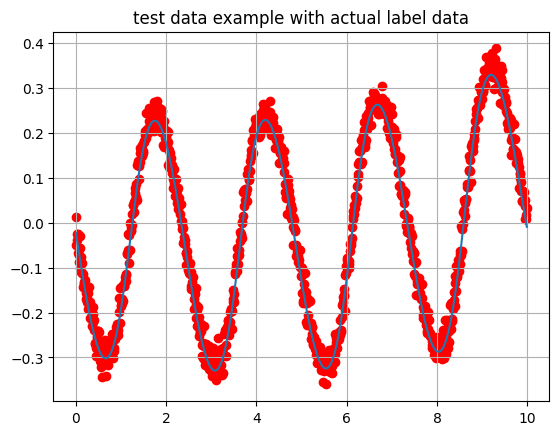

In [ ]:
plt.title('test data example with actual label data')
plt.plot(ex_time, x_proto[1800], label='generated data from defined function')
##########################################################################
plt.scatter(ex_time, x[1800], c='r', label = 'data with noise')
plt.grid()
plt.show()

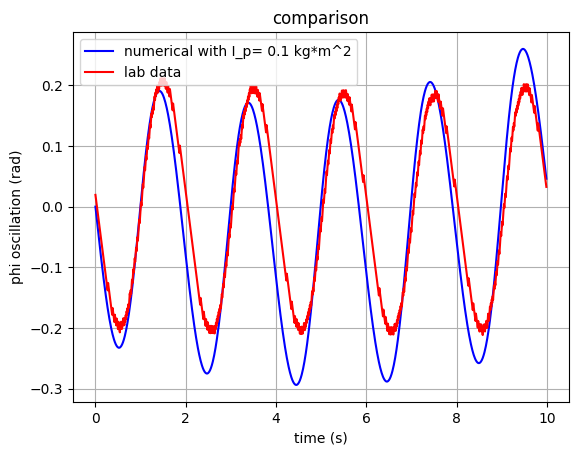

In [ ]:
plt.title('comparison')
plt.plot( ex_time, total_run(0.100,1), c='b', label = 'numerical with I_p= 0.1 kg*m^2')
plt.plot(time_pR1, slope_avg(AzimAng_pR1), c='r', label='lab data')
plt.xlabel('time (s)')
plt.ylabel('phi oscillation (rad)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader  # storing the generated dataset

X_train = torch.Tensor(x_train)
X_test = torch.Tensor(x_test)
Y_train = torch.LongTensor(y_train)
Y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, Y_train)
ds_test = TensorDataset(X_test, Y_test)

loader_train = DataLoader(ds_train, batch_size=128, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=128, shuffle=False)

In [ ]:
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(1000,1024))
model.add_module('ReLU1', nn.ReLU())
model.add_module('fc2', nn.Linear(1024,512))
model.add_module('ReLU2', nn.ReLU())
model.add_module('fc3', nn.Linear(512,256))
model.add_module('ReLU3', nn.ReLU())
model.add_module('fc4', nn.Linear(256,I_num))

from torch import optim

# Selecting the loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer selection: ADAM
optimizer = optim.Adam(model.parameters(), lr=0.01) # 0.01

In [ ]:
def train(epoch):
    model.train()  # train mode

    for data, targets in loader_train:

        optimizer.zero_grad()  # initialize the gradient value
        outputs = model(data)  # evaluate the output of the model from the input
        loss = loss_fn(outputs, targets)  # evaluate the loss
        loss.backward()  # Back Propagation
        optimizer.step()  # and modify the parameters

    #print("epoch{}: completed \n".format(epoch))

In [ ]:
def test():
    model.eval()  # Evaluation
    correct = 0

    with torch.no_grad():  # No gradient required
        for data, targets in loader_test:

            outputs = model(data)

            # predicting section
            _, predicted = torch.max(outputs.data, 1)  # Evaluating the most valid case
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # giving a score for the right answer

   # Accuracy of the model
    data_num = len(loader_test.dataset)  # Total number of problems
    print('\n Obtained Accuracy from the test data set: {}/{} ({:.2f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))

In [ ]:
for epoch in range(0,500):
  train(epoch)
print("epoch{}：complete\n".format(epoch+1))

test()

epoch500：완료


테스트 데이터에서 예측 정확도: 788/1000 (78.80%)



finding the desired moment of inertia value

<class 'torch.Tensor'>
예측 결과 : I_p: 0.1015 kg*m^2 




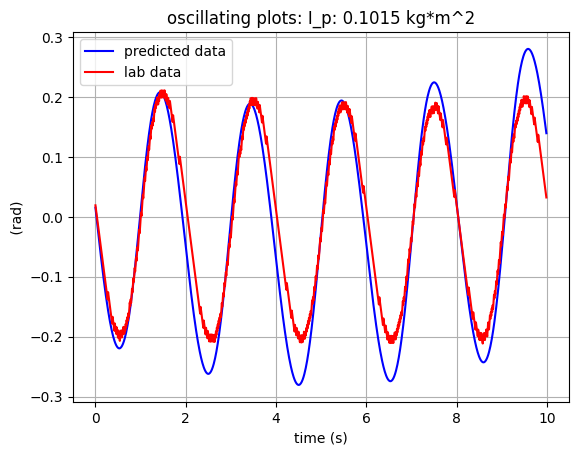

In [ ]:
#Find I_p, the moment of inertia value of the gyroscope. -> fitting by plugging the lab data inside

model.eval()
data1 = slope_avg(AzimAng_pR1)
#data = torch.from_numpy(data)
data1 = torch.Tensor(data1)

print(type(data1))

output = model(data1)
_, predicted = torch.max(output.data, 0)

true_I_p = I_p_list[predicted]

print("Predicted value of I'(I_p): {} kg*m^2".format(true_I_p), "\n\n")

plt.title('oscillating plots: I_p: {} kg*m^2'.format(true_I_p))
plt.plot(ex_time, total_run(true_I_p), label='predicted data', c='b')
plt.plot(ex_time, slope_avg(AzimAng_pR1), label = 'lab data', c='r')
plt.xlabel('time (s)')
plt.ylabel(' (rad) ')

plt.legend()
plt.grid()
plt.show()


comparing it with actual experimental results and the numerically plotted result with the I' found from supervised Learning (classification)

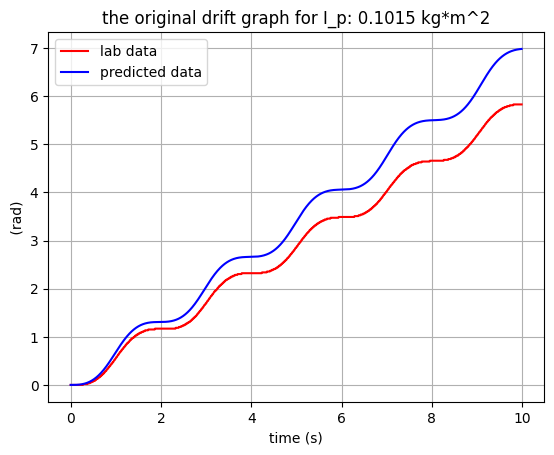

In [ ]:
plt.title('the original drift graph for I_p: {} kg*m^2'.format(true_I_p))
plt.plot(ex_time, AzimAng_pR1, label='lab data', c='r')
plt.plot(ex_time, gen_phi(true_I_p), label='predicted data', c='b')
plt.xlabel('time (s)')
plt.ylabel(' (rad) ')
plt.legend()
plt.grid()
plt.show()

#Applying PINN

In [ ]:
pinn_time = np.arange(0,10,0.02)
PHI, THETA = gen_phi(true_I_p,1)

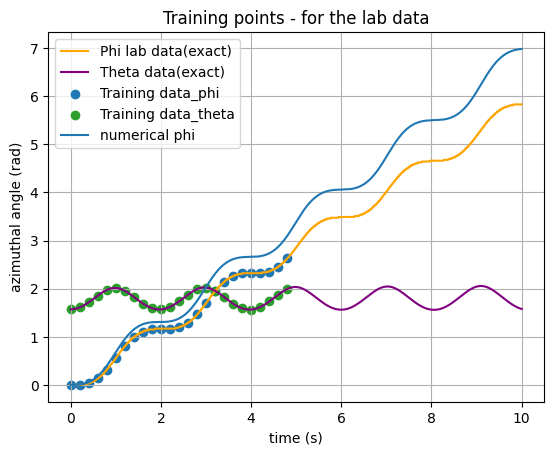

tensor([[0.0000, 1.5708],
        [0.0000, 1.6109],
        [0.0350, 1.7179],
        [0.1400, 1.8569],
        [0.3150, 1.9748],
        [0.5590, 2.0151],
        [0.8030, 1.9551],
        [0.9950, 1.8279],
        [1.1000, 1.6915],
        [1.1520, 1.5954],
        [1.1700, 1.5695],
        [1.1700, 1.6217],
        [1.2050, 1.7366],
        [1.2920, 1.8780],
        [1.4670, 1.9920],
        [1.6930, 2.0238],
        [1.9550, 1.9555],
        [2.1470, 1.8240],
        [2.2690, 1.6870],
        [2.3220, 1.5920],
        [2.3220, 1.5672],
        [2.3220, 1.6197],
        [2.3570, 1.7349],
        [2.4610, 1.8779],
        [2.6360, 1.9964]])


In [ ]:
# Bringing the raw data renewal.ver in the flesh.
time_pR1=[]
AzimAng_pR1=[]

for idx in range(0,1000): #1703
  time_pR1.append(data_ren['time1'][idx+135]-data_ren['time1'][135])
  AzimAng_pR1.append(data_ren['CCW run1'][idx+135]-data_ren['CCW run1'][135])

time_torch = torch.linspace(0,10,1000).view(-1,1)
p = torch.from_numpy(np.asarray(AzimAng_pR1))
phi_torch = torch.Tensor(p).view(-1,1) ###########
#p1 = torch.Tensor(pp_new)
theta_torch = torch.Tensor(THETA).view(-1,1)
PHInum_torch = torch.Tensor(PHI).view(-1,1)

t_data = time_torch[0:500:20].view(-1,1)
phi_data = phi_torch[0:500:20].view(-1,1)
theta_data = theta_torch[0:500:20].view(-1,1)
#p1_data = p1[0:500:50]

data = np.concatenate((phi_data, theta_data)).reshape(2, len(t_data)).T
data = torch.Tensor(data).view(-1,2)

plt.figure(dpi=300)
plt.title("Training points - for the lab data")
plt.plot(time_torch, phi_torch, label="Phi lab data(exact)", c='orange')
plt.plot(time_torch, theta_torch, label="Numerical Theta", c='purple')
plt.scatter(t_data, phi_data, color="tab:blue", label="Training data_phi")
plt.scatter(t_data, theta_data, color="tab:green", label="Training data_theta")
#plt.plot(t, p1, label="numerical", c='blue')
#plt.scatter(t_data, p1_data, color="tab:blue", label="Training data")
plt.plot(time_torch, PHInum_torch, label='numerical phi')
plt.xlabel('time (s)')
plt.ylabel('azimuthal angle (rad)')
plt.grid()
plt.legend()
plt.show()

print(data)

In [ ]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


def plot_my_result(t, phi, phi_lab, theta, t_data, data, pred, ps=None):

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    fig.suptitle(name_plot, fontsize=10)

    # exact points
    plt.plot(t, phi, 'k--', linewidth=2, alpha=0.8, label="numerical solution $phi$")
    plt.plot(t, phi_lab, 'r--', linewidth=2, alpha=0.8, label="lab data $phi$")
    plt.plot(t, theta, 'b--', linewidth=2, alpha=0.8, label=r"numerical solution $\theta$")


    # training points
    plt.scatter(t_data, data[:,0], s=30, color="red", label='Training data $phi$')
    plt.scatter(t_data, data[:,1], s=30, color="royalblue", label=r'Training data $\theta$')

    # Physics loss point:
    if ps is not None:
        plt.scatter(ps, -3*torch.ones_like(ps), s=20, color="limegreen", alpha=0.4, label='physics trainings')

    # Prediction line
    plt.plot(t, pred[:,0], color="orange", linewidth=2, alpha=0.8, label="Prediction $phi$")
    plt.plot(t, pred[:,1], color="blue", linewidth=2, alpha=0.8, label=r"Prediction $\theta$")

    # plot
    plt.text(torch.max(t)*1.01,torch.max(data),"episode: %i"%(i),fontsize=16,color="k")
    x_max = torch.max(t)
    y_min = torch.min(pred[:,1])
    y_max = torch.max(pred[:,1])

    plt.xlim(0, 10)
    plt.ylim(-0.5, 7)

    l = plt.legend(loc=('upper left'), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.axis("off")

In [ ]:
class Network(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

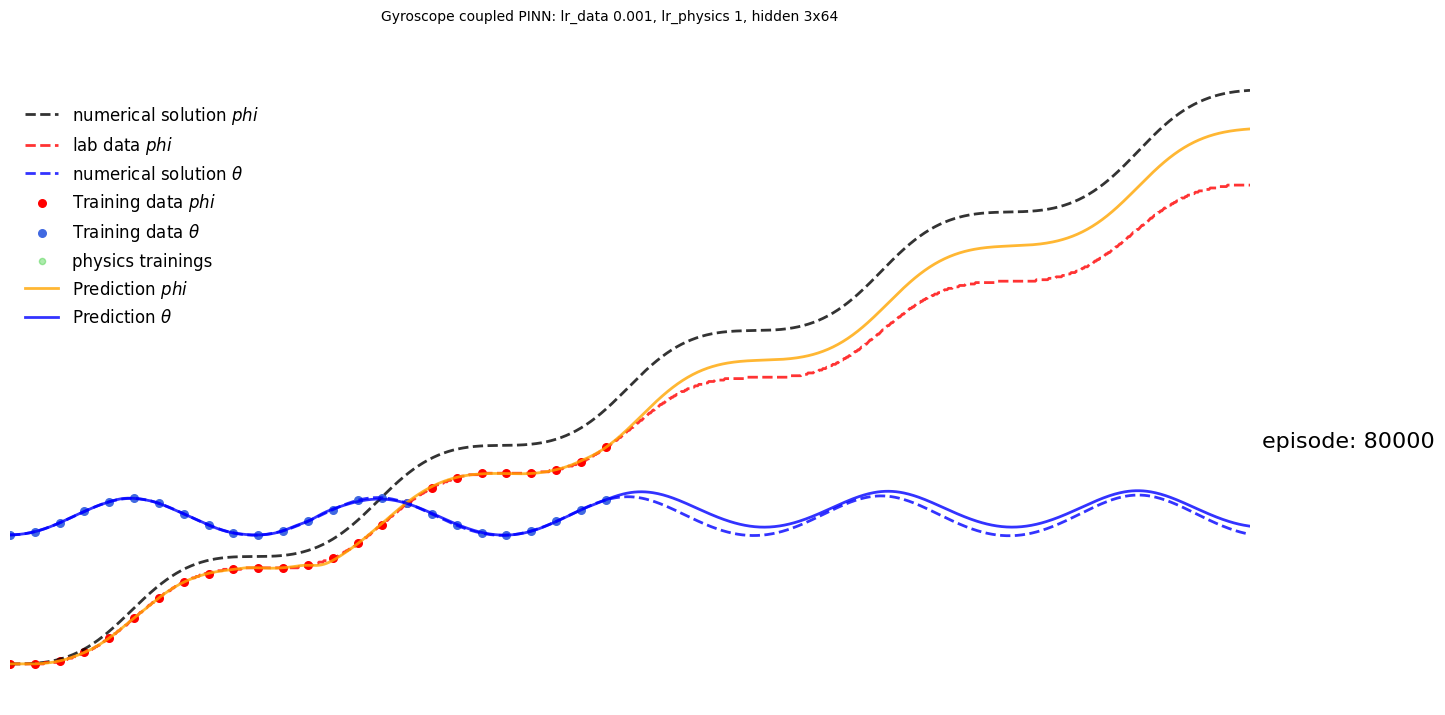

duration: 609 [s]


In [ ]:
%matplotlib inline
import time
from torch import sin, cos

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Residual of the differential equation evaluated based on 50 evaluation points.
eval_point = 50
t_physics = torch.linspace(0,10,eval_point).view(-1,1).requires_grad_(True)

# transforming the angular speed in order to calculate the physics loss
w_eval = []
for final_index in range(0,eval_point):
  w_eval.append(1/(1/2160 * (round(10/eval_point, 2)*final_index) + 1/27))
w_eval = np.asarray(w_eval)
w_eval = torch.Tensor(w_eval).view(-1,1)

#m = 0.1
#d = 0.21
#g = 9.80665
#I = 0.0105
#I_p = 0.0982

torch.manual_seed(123)

# hyp prmtr
lr_data = 0.001  #1e-3 default
lr_physics = 1  # The case for not applying PINN would be the case of setting lr_physics as 0, 1 would be a proper value
num_layers = 3   #trial 1: 3(default)
num_hidden = 64

model = Network(1,2,num_hidden,num_layers)
optimizer = torch.optim.Adam(model.parameters(),lr=lr_data)

episodes = 80000
num_plots = 200

files = []
name_plot = 'Gyroscope coupled PINN: lr_data %s, lr_physics %s, hidden %sx%s'%(lr_data, lr_physics,num_layers, num_hidden)
name_gif = '/content/drive/MyDrive/Colab Notebooks/AI Physics textbook projects/23-2 project folder/Gyroscope Classification, PINN/PINN_Lab_data_ver_lr_data_%s_lr_physics_%s_hidden_%sx%s_episodes_%s.gif'%(lr_data, lr_physics,num_layers, num_hidden, episodes)
#make sure to revise the path of the files when running the code.

file_name = input("file name to store the GIF: ")

start = time.time()
for i in range(1, episodes+1):

    optimizer.zero_grad()

    # normal Loss
    pred = model(t_data)
    loss_data = torch.mean((pred - data)**2)

    # Prediction - t_physics
    pred = model(t_physics)

    # phi_prediction
    phi_p = pred[:,0].view(-1,1)
    phi_d_p = torch.autograd.grad(phi_p, t_physics, torch.ones_like(phi_p), create_graph=True)[0]
    phi_dd_p = torch.autograd.grad(phi_d_p, t_physics, torch.ones_like(phi_d_p), create_graph=True)[0]

    # theta_prediction
    theta_p = pred[:,1].view(-1,1)
    theta_d_p = torch.autograd.grad(theta_p, t_physics, torch.ones_like(theta_p), create_graph=True)[0]
    theta_dd_p = torch.autograd.grad(theta_d_p, t_physics, torch.ones_like(theta_d_p), create_graph=True)[0]

    sin_theta_p = sin(theta_p)
    cos_theta_p = cos(theta_p)

    # Physics Loss
    physics_phi = true_I_p*(theta_dd_p-(phi_d_p**2)*sin_theta_p*cos_theta_p)+I*w_eval*phi_d_p*sin_theta_p-m*g*d*sin_theta_p
    physics_theta = -true_I_p*(phi_dd_p*sin_theta_p+2*phi_d_p*theta_d_p*cos_theta_p)+I*w_eval*theta_d_p
    loss_physics = torch.mean(physics_phi**2) + torch.mean(physics_theta**2)


    loss = loss_data +lr_physics * loss_physics
    loss.backward()
    optimizer.step()

    # vis
    if (i % (episodes/num_plots)) == 0:

        pred = model(time_torch).detach()
        ps = t_physics.detach()
        #print(loss_data, loss_physics)
        #print(type(pred[:,0]))

        plot_my_result(time_torch, PHInum_torch, np.asarray(AzimAng_pR1), THETA, t_data, data, pred, ps)


        file = file_name+"/pinn_%.8i.png"%(i)
        # If the code is running in google colab, make sure to create a folder named plots in order to save the images to create the desired GIF
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        # show 5 plots
        if (i % (episodes)) == 0: plt.show()
        else: plt.close("all")


print('duration: %s [s]' % round(time.time() - start))

In [ ]:
save_gif_PIL(name_gif, files, fps=15, loop=0)